In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

nx = 800
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
print(targetNeighbors)
CFL = 0.3

gamma = 5/3
initialStateLeft = sodInitialState(1, 1, 0)
initialStateRight = sodInitialState(0.1795, 0.25, 0)
ratio = 4
smoothIC = True
timeLimit = 0.15

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.MonaghanScheme

domain = buildDomainDescription(l = 1, dim = 1, periodic = True, device = device, dtype = dtype)


8.0


In [3]:

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
# particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

# dt = computeDT(particleSystem.systemState, CFL, solverConfig)
# timesteps = int(timeLimit / dt)

In [4]:
A = 1e-6
lamda = 1
rho0 = 1.0
c_s = 1
gamma = 5/3

scheme, simulationSystem, domain, P0, config, integrator = buildLinearWaveSimulation(
    nx = nx, l = 1, A = A, lamda = lamda, rho0 = rho0, c_s = c_s, gamma = gamma, device = device, dtype = dtype, kernel = kernel, verbose = False, simulationScheme=SimulationScheme.CompSPH, viscositySwitch=ViscositySwitch.NoneSwitch, integrationScheme = IntegrationSchemeType.rungeKutta2, supportScheme=AdaptiveSupportScheme.MonaghanScheme)

    

nx 800
800
	Iteration 0 - Sampling Error: 3.19e-07
	Iteration 1 - Sampling Error: 1.53e-13
	Iteration 2 - Sampling Error: 5.61e-22
	Iteration 3 - Sampling Error: 2.17e-29
	Iteration 4 - Sampling Error: 1.48e-29
	Iteration 5 - Sampling Error: 1.42e-29
	Iteration 6 - Sampling Error: 1.35e-29
	Iteration 7 - Sampling Error: 1.29e-29
	Iteration 8 - Sampling Error: 1.23e-29
	Iteration 9 - Sampling Error: 1.18e-29
	Iteration 10 - Sampling Error: 1.13e-29
	Iteration 11 - Sampling Error: 1.08e-29
	Iteration 12 - Sampling Error: 1.04e-29
	Iteration 13 - Sampling Error: 9.98e-30
	Iteration 14 - Sampling Error: 9.57e-30
	Iteration 15 - Sampling Error: 9.13e-30


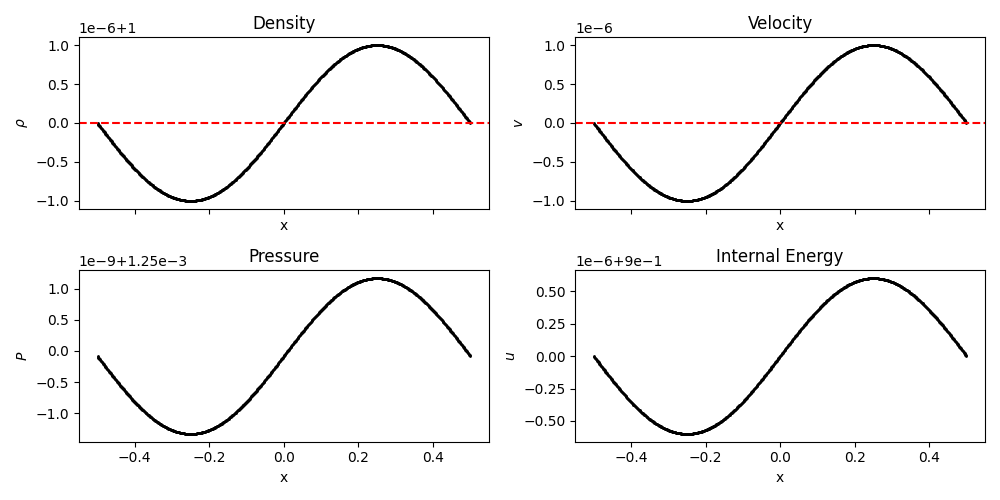

In [5]:
particles = simulationSystem.systemState

fig, axis = plt.subplots(2,2, figsize = (10,5), squeeze=False, sharex=True, sharey=False)

axis[0,0].scatter(particles.positions.cpu().numpy(), particles.densities.cpu().numpy(), color = 'black', s = 1)
axis[0,0].axhline(y = rho0, color = 'red', linestyle = '--')
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel(r'$\rho$')

axis[0,1].scatter(particles.positions.cpu().numpy(), particles.velocities.cpu().numpy(), color = 'black', s = 1)
axis[0,1].axhline(y = 0, color = 'red', linestyle = '--')
axis[0,1].set_title('Velocity')
axis[0,1].set_xlabel('x')
axis[0,1].set_ylabel(r'$v$')

axis[1,0].scatter(particles.positions.cpu().numpy(), particles.masses.cpu().numpy(), color = 'black', s = 1)
# axis[1,0].axhline(y = P0, color = 'red', linestyle = '--')
axis[1,0].set_title('Pressure')
axis[1,0].set_xlabel('x')
axis[1,0].set_ylabel(r'$P$')

axis[1,1].scatter(particles.positions.cpu().numpy(), particles.internalEnergies.cpu().numpy(), color = 'black', s = 1)

axis[1,1].set_title('Internal Energy')
axis[1,1].set_xlabel('x')
axis[1,1].set_ylabel(r'$u$')

fig.tight_layout()
# display(fig)

In [6]:
particles.positions[1] - particles.positions[0]

tensor([0.0012], dtype=torch.float64)

In [7]:
1/particles.positions.shape[0] - (particles.positions[1] - particles.positions[0])

tensor([2.6671e-17], dtype=torch.float64)

In [8]:

# integrator = RungeKutta2

MAE, s0, s1, systemStates, energies, L1, L2, Linf = runLinearWaveTest(
    nx = 126,
    l = 1,

    A = 1e-6,
    lamda = 1,
    rho0 = 1,

    c_s = 1,
    gamma = solverConfig['fluid']['gamma'],

    targetNeighbors = solverConfig['targetNeighbors'],
    device = device,
    dtype = dtype,
    kernel = kernel,
    verbose = False,
    periods = 3.0,
    CFLNumber = 0.1, simulationScheme=SimulationScheme.CompSPH, viscositySwitch=ViscositySwitch.NoneSwitch, integrationScheme = IntegrationSchemeType.rungeKutta2, supportScheme=AdaptiveSupportScheme.MonaghanScheme
)

nx 126
126
	Iteration 0 - Sampling Error: 7.80e-09
	Iteration 1 - Sampling Error: 5.45e-15
	Iteration 2 - Sampling Error: 4.02e-21
	Iteration 3 - Sampling Error: 6.25e-27
	Iteration 4 - Sampling Error: 1.45e-31
	Iteration 5 - Sampling Error: 1.20e-31
	Iteration 6 - Sampling Error: 9.46e-32
	Iteration 7 - Sampling Error: 8.27e-32
	Iteration 8 - Sampling Error: 8.84e-32
	Iteration 9 - Sampling Error: 7.84e-32
	Iteration 10 - Sampling Error: 6.26e-32
	Iteration 11 - Sampling Error: 8.89e-32
	Iteration 12 - Sampling Error: 8.09e-32
	Iteration 13 - Sampling Error: 7.37e-32
	Iteration 14 - Sampling Error: 8.63e-32
	Iteration 15 - Sampling Error: 8.83e-32


  0%|          | 0/3781 [00:00<?, ?it/s]

Closest index: 4, 126.0
1.0
tensor(1.0000, dtype=torch.float64) 0.0007934408886537953
float64 float64 float64
Time Difference: 3.0000000000001066, c_s: 0.9999999999998056 | 0.9999999999998574
Wave Lengths: 3.00000000000069
Mean Absolute Error (wrt reference): 7.499214608644665e-08
Mean Absolute Error (wrt actual): 7.499214608644665e-08
Closest index: 4, 126.0
Should be 1.06720681e-07 [normal] or 3.266813e-09 [0 viscosity] or 2.3293332999999996e-08 [cullen]
Ratio: 0.7026955355208673 or 22.95575109026646 or 3.2194682524156875


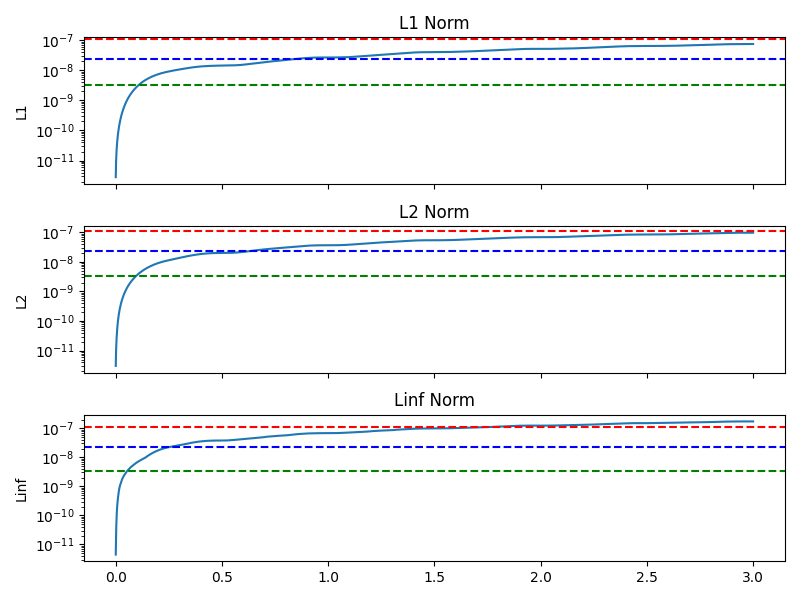

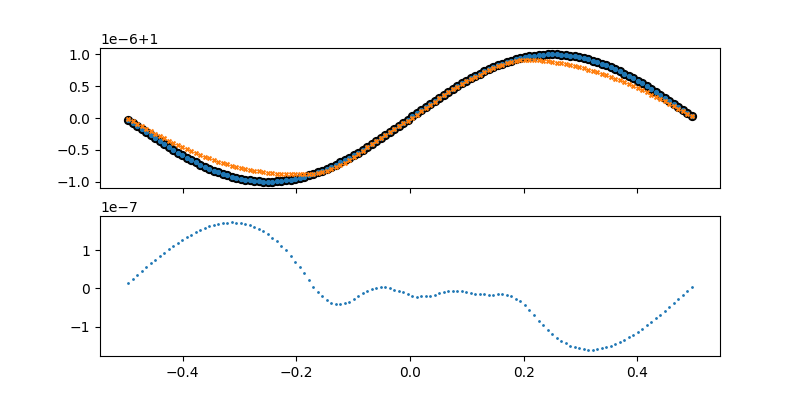

In [9]:
from sphMath.reference.linear import compSPHData, compSPHQ0Data, compSPHCullenData
import numpy as np

fig, axis = plt.subplots(3,1, figsize = (8,6), squeeze=False, sharex=True)

axis[0,0].plot([s.t for s in systemStates[1:]], L1)
axis[0,0].set_title('L1 Norm')
axis[0,0].set_ylabel('L1')
axis[0,0].set_yscale('log')

axis[1,0].plot([s.t for s in systemStates[1:]], L2)
axis[1,0].set_title('L2 Norm')
axis[1,0].set_ylabel('L2')
axis[1,0].set_yscale('log')

axis[2,0].plot([s.t for s in systemStates[1:]], Linf)
axis[2,0].set_title('Linf Norm')
axis[2,0].set_ylabel('Linf')
axis[2,0].set_yscale('log')

nx = systemStates[-1].systemState.soundspeeds.shape[0]
closestIndex = -1
dist = 1e9
for i, (x, y) in enumerate(zip(compSPHData[0], compSPHData[1])):
    if np.abs(nx - x) < dist:
        dist = np.abs(nx - x)
        closestIndex = i
print(f'Closest index: {closestIndex}, {compSPHData[0][closestIndex]}')
target = compSPHData[1][closestIndex]
target2 = compSPHQ0Data[1][closestIndex]
target3 = compSPHCullenData[1][closestIndex]

for ax in axis.flatten():
    ax.axhline(y = target, color = 'red', linestyle = '--')
    ax.axhline(y = target2, color = 'green', linestyle = '--')
    ax.axhline(y = target3, color = 'blue', linestyle = '--')

fig.tight_layout()


i0 = 0
i1 = -1
rho0 = systemStates[i0].systemState.densities.cpu().numpy().mean()
print(rho0)
rho0 = 1
A = 1e-6

c_ = 1
c_ = systemStates[i1].systemState.soundspeeds.mean()
dt = systemStates[i0+1].t - systemStates[i0].t
print(c_, dt)
time = systemStates[i1].t #+ dt * 2

rho_reference = (rho0 +  A * torch.sin(2 * np.pi * systemStates[i1].systemState.positions[:,0] / lamda - time * c_ / lamda * 2 * np.pi)).cpu().numpy()
rho0 = systemStates[i0].systemState.densities.cpu().numpy()
rho1 = systemStates[i1].systemState.densities.cpu().numpy()

print(rho1.dtype, rho0.dtype, rho_reference.dtype)

tdiff = systemStates[i1].t - systemStates[i0].t
print(f'Time Difference: {tdiff}, c_s: {systemStates[i0].systemState.soundspeeds.mean()} | {systemStates[i1].systemState.soundspeeds.mean()}')
c_s = systemStates[i0].systemState.soundspeeds.mean()
print(f'Wave Lengths: {tdiff / c_s}')


fig, axis = plt.subplots(2,1, figsize = (8,4), squeeze=False, sharex=True)
axis[0,0].scatter(systemStates[i0].systemState.positions.cpu().numpy(), rho0, color = 'black', s =32)
axis[0,0].scatter(systemStates[i1].systemState.positions.cpu().numpy(), rho_reference, s = 8)
axis[0,0].scatter(systemStates[i1].systemState.positions.cpu().numpy(), rho1, s = 8, marker = 'x')


AE = ((rho1 - rho_reference))
axis[1,0].scatter(systemStates[i1].systemState.positions.cpu().numpy(), AE, s = 1)

print(f'Mean Absolute Error (wrt reference): {np.abs(AE).mean()}')

# AE = np.abs((rho1 - rho0))
# axis[1,0].scatter(systemStates[i1].systemState.positions.cpu().numpy(), AE, color = 'blue', s = 1)

print(f'Mean Absolute Error (wrt actual): {np.abs(AE).mean()}')

# print(f'Should be {4342.49829811*1e-11} or {128.83763231*1e-11}')

nx = systemStates[i1].systemState.soundspeeds.shape[0]
closestIndex = -1
dist = 1e9
for i, (x, y) in enumerate(zip(compSPHData[0], compSPHData[1])):
    if np.abs(nx - x) < dist:
        dist = np.abs(nx - x)
        closestIndex = i
print(f'Closest index: {closestIndex}, {compSPHData[0][closestIndex]}')
target = compSPHData[1][closestIndex]
target2 = compSPHQ0Data[1][closestIndex]
target3 = compSPHCullenData[1][closestIndex]
print(f'Should be {target} [normal] or {target2} [0 viscosity] or {target3} [cullen]')
print(f'Ratio: {np.abs(AE).mean() / target} or {np.abs(AE).mean() / target2} or {np.abs(AE).mean() / target3}')

# display(fig)

In [8]:
results = []
# for nx in (t:=tqdm([20, 31, 50, 59, 126, 200, 316, 502, 796, 1261, 2000])):
for nx in (t:=tqdm([20, 31, 50, 80, 126, 200, 316])):
    MAE, s0, s1, *_ = runLinearWaveTest(
        simulator,
        integrator.function,
        solverConfig,
        nx = nx,
        l = 1,

        A = 1e-6,
        lamda = 1,
        rho0 = 1,

        c_s = 1,
        gamma = solverConfig['gamma'],

        targetNeighbors = solverConfig['targetNeighbors'],
        device = torch.device('cpu'),
        dtype = torch.float64,
        kernel = kernel,
        periods = 5
    )
    results.append({
        'MAE': MAE,
        'nx': nx,
        's0': s0,
        's1': s1
    })
    t.set_description(f'MAE: {MAE} nx: {nx}')

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1551 [00:00<?, ?it/s]

  0%|          | 0/2501 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/6301 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/15801 [00:00<?, ?it/s]

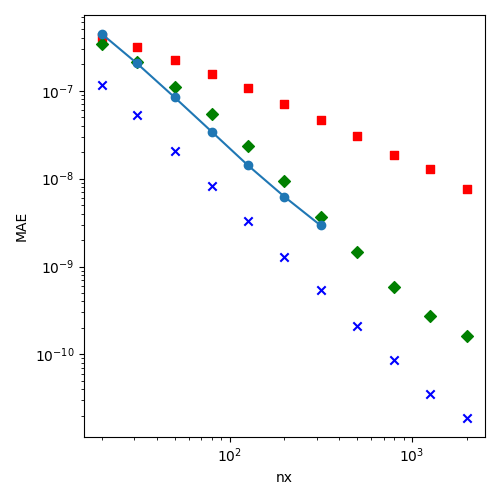

In [10]:
fig, axis = plt.subplots(1,1, figsize = (5,5), squeeze=False)

axis[0,0].plot([r['nx'] for r in results], [r['MAE'] for r in results], marker = 'o')

for x,y in zip(compSPHQ0Data[0], compSPHQ0Data[1]):
    axis[0,0].scatter(x, y, color = 'blue', marker = 'x')
for x,y in zip(compSPHData[0], compSPHData[1]):
    axis[0,0].scatter(x, y, color = 'red', marker = 's')
for x,y in zip(compSPHCullenData[0], compSPHCullenData[1]):
    axis[0,0].scatter(x, y, color = 'green', marker = 'D')

axis[0,0].set_xlabel('nx')
axis[0,0].set_ylabel('MAE')

axis[0,0].set_xscale('log')
axis[0,0].set_yscale('log')

fig.tight_layout()
